In [2]:
import csv
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

source = "en"   
target=["nl", "es", "zh"]
languages = ["es", "nl", "en", "zh"]

language_names = {"en": "English", "ms": "Malay", "pt":"Portuguese", "fr": "French", "id": "Indonesian", 
                  "nl": "Dutch", "es": "Spanish", "zh": "Chinese", "ru": "Russian"}

In [3]:
from src.util import load_fb_dictionaries, load_worldlex_data, expand_chinese_characters
from src.util import load_strong_translations, load_worldlex_data
from src.word_mapping import calculate_frequency, get_wordlist

def preprocess_fq(lang_word_fq, column_name="avg"):
    return {lang: {word: {column_name: fq} for word, fq in word_fq.items()} for lang, word_fq in lang_word_fq.items()}

# worldlex frequency
freq = load_worldlex_data(relative_frequency=False, average=False, source=["twitter", "blog"], languages=languages)
strong_translations = load_strong_translations(languages, folder_path="strong-translations/lemma-strong-translations-0.2", source="en_lemma")

freq["zh"] = expand_chinese_characters(freq["zh"], convert="key", count_values=True)


#### 0. Loading SWOW assoc. data

In [4]:
from src.util import load_swow_from_agg_data

r1_fq, r1_tp, r1_split_fq, r123_split_fq, r123_fq, r123_tp, cue_r1_fq, cue_r123_fq, r1_cue_fq, cue_r1_strength, r123_cue_fq, cue_r123_strength = {}, {}, {}, {},\
{}, {}, {}, {}, {}, {}, {}, {}

# load English and Chinese
r1_fq["en"], r1_split_fq["en"], r1_tp["en"], cue_r1_fq["en"], r1_cue_fq["en"], cue_r1_strength["en"] = load_swow_from_agg_data(
    "small-world/strength.SWOW-EN.R1.csv", delimiter="\t", cue_name="cue", response_name="response", fq_name="R1", strength_name="R1.Strength")
r123_fq["en"], r123_split_fq["en"], r123_tp["en"], cue_r123_fq["en"], r123_cue_fq["en"], cue_r123_strength["en"] = load_swow_from_agg_data(
    "small-world/strength.SWOW-EN.R123.csv", delimiter="\t", cue_name="cue", response_name="response", fq_name="R123", strength_name="R123.Strength")
r1_fq["zh"], r1_split_fq["zh"], r1_tp["zh"], cue_r1_fq["zh"], r1_cue_fq["zh"], cue_r1_strength["zh"] = load_swow_from_agg_data(
    "small-world/strength.SWOW-ZH.R1.03-12-2021.csv", delimiter="\t", cue_name="cue", response_name="response", fq_name="R1", strength_name="R1.Strength")
r123_fq["zh"], r123_split_fq["zh"], r123_tp["zh"], cue_r123_fq["zh"], r123_cue_fq["zh"], cue_r123_strength["zh"] = load_swow_from_agg_data(
    "small-world/strength.SWOW-ZH.R123.03-12-2021.csv", delimiter="\t", cue_name="cue", response_name="response", fq_name="R123", strength_name="R123.Strength")

# load Dutch and Spanish
from src.util import load_swow_responses

r1_fq["nl"], r123_fq["nl"], r1_split_fq["nl"], r123_split_fq["nl"], r1_tp["nl"], r123_tp["nl"], \
cue_r1_strength["nl"], cue_r123_strength["nl"], cue_r1_fq["nl"], cue_r123_fq["nl"] = load_swow_responses(
    "small-world/associationData-NL.csv", delimiter=';', cue_name="cue", r123_name=["asso1", "asso2", "asso3"], ignored_responses=["NA", "x"])

r1_fq["es"], r123_fq["es"], r1_split_fq["es"], r123_split_fq["es"], r1_tp["es"], r123_tp["es"], \
cue_r1_strength["es"], cue_r123_strength["es"], cue_r1_fq["es"], cue_r123_fq["es"] = load_swow_responses(
    "small-world/SWOW-RP.R70.csv", delimiter=',',cue_name="cue", r123_name=["R1", "R2", "R3"], ignored_responses=["NA"])

In [5]:
for lang in languages:
    print("number of r1s in {}: {}".format(lang, sum(r1_fq[lang].values())))
    print("number of r123s in {}: {}".format(lang, sum(r123_fq[lang].values())))

number of r1s in es: 899436
number of r123s in es: 2103790
number of r1s in nl: 1239208
number of r123s in nl: 3646739
number of r1s in en: 1190891
number of r123s in en: 3385951
number of r1s in zh: 594762
number of r123s in zh: 1415761


##### Convert Chinese assoc characters

In [6]:
import opencc
converter = opencc.OpenCC('t2s.json')
from collections import Counter
from src.util import expand_chinese_characters

zh_r123_fq = expand_chinese_characters(r123_fq["zh"], convert="key", count_values=True)
zh_cue_r123_fq = expand_chinese_characters(cue_r123_fq["zh"], convert="key", count_values=True)
zh_cue_r123_fq = expand_chinese_characters(zh_cue_r123_fq, convert="value", count_values=True)

print("number of r123s in zh: {}".format( sum(zh_r123_fq.values())))

number of r123s in zh: 1415761


In [7]:
r123_fq["zh"] = zh_r123_fq
cue_r123_fq["zh"] = zh_cue_r123_fq

##### Bayesian on responses

In [8]:
from src.statistics import get_alphas, get_n, final_score, rank_keyword_score
from src.evaluation import sort_rank_by_score
from src.word_association import get_usage_assoc_alignment
from src.word_association import get_wordlist_scores
r_smoothing_param = 1
source = "en_lemma"


# {w: S_w}
sc = {}
# [words sorted by S_w]
sorted_sc = {}
# {w: ranking by S_w, words of same ranks have same S_w}
word_sc_rank = {}
wordlist, word_stat = {}, {}

clf_lang_word_score, clf_ranks, clf_rank_keyword_score  = {}, {}, {}

for method_name, method in { "r123_fq": r123_fq}.items():
    word_stat[method_name], wordlist[method_name], _, _, _, _, _, _ = get_wordlist_scores(method, r_smoothing_param, languages, strong_translations, translate=True)
    

##### Shared vocabulary

In [9]:
from src.word_association import translate_cue_response_stat

cuetr_r123_fq = translate_cue_response_stat(cue_r123_fq, languages, strong_translations, source, translate="cue")       
                    
cuetr_r123tr_fq = translate_cue_response_stat(cuetr_r123_fq, languages, strong_translations, source, translate="response")

In [10]:
shared_vocabulary = set(cuetr_r123tr_fq["en"].keys()).union(set(word_stat["r123_fq"]["en"].keys()))
for lang, r123s in word_stat["r123_fq"].items():
    lang_vocab = set(cuetr_r123tr_fq[lang].keys()).union(set(r123s.keys()))
    shared_vocabulary = shared_vocabulary.intersection(lang_vocab)

print("Total size of shared vocabulary: {}".format(len(shared_vocabulary)))

Total size of shared vocabulary: 4514


#### 0. Controlling vocabulary

Maximum and minimum cue frequencies
es, max: 166, min: 23
nl, max: 252, min: 43
en, max: 263, min: 45
zh, max: 161, min: 10


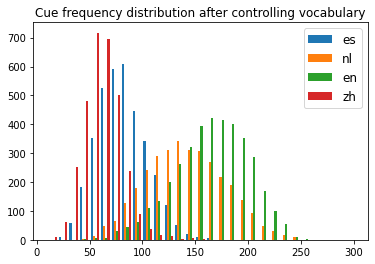

Number of shared_cues: 2224
Number of cues after filtering
{'es': 2224, 'nl': 2224, 'en': 2224, 'zh': 2224}
{'es': 66719.99999999924, 'nl': 66719.99999999924, 'en': 66719.99999999924, 'zh': 66719.99999999924}


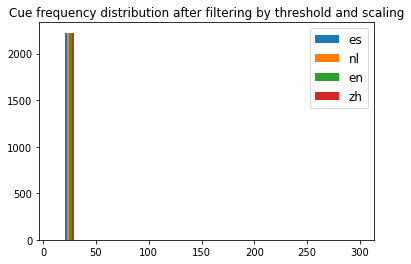

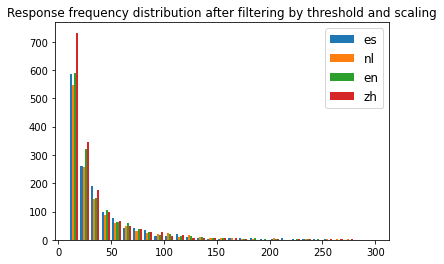

{'es': 66719.99999999774, 'nl': 66719.99999999766, 'en': 66719.99999999788, 'zh': 66719.99999999789}


In [11]:
import warnings
import copy 
from src.word_association import get_rescaled_response_distribution_with_uniform_cues

# rescaled and controlled both cues and responses
cr123ccuersc_fq, ccuersc_cr123_fq, shared_cues = get_rescaled_response_distribution_with_uniform_cues(cuetr_r123tr_fq, shared_vocabulary, cue_fq_threshold=30, verbose=True)
cr123ccuersc_n = {lang: sum(rfq.values()) for lang, rfq in cr123ccuersc_fq.items()}
print(cr123ccuersc_n)


#### 1. Bayesian on assoc

In [12]:
# from src.statistics import final_score, rank_keyword_score, get_alphas, get_n, proportion_score, frequency_score,\
# rank_keyword_by_freq_score
from src.evaluation import sort_rank_by_score
from src.statistics import sort_tuple_score, get_recall_at_k
clf_tuple = {}
assoc_smoothing_param  = 1   
method_name = "cr123ccuersc_fq"
word_stat[method_name], wordlist[method_name], clf_lang_word_score[method_name], clf_ranks[method_name], clf_rank_keyword_score[method_name], \
sc[method_name], sorted_sc[method_name], word_sc_rank[method_name] = get_wordlist_scores(cr123ccuersc_fq, assoc_smoothing_param, languages, strong_translations, 
                                                                                             translate=False)

clf_tuple[method_name] = sort_tuple_score(clf_lang_word_score[method_name])

In [13]:
print({lang: len(rfq) for lang, rfq in word_stat["cr123ccuersc_fq"].items()})

{'es': 4514, 'nl': 4514, 'en': 4514, 'zh': 4514}


In [14]:
print({lang: sum(word_stat.values()) for lang, word_stat in word_stat["cr123ccuersc_fq"].items()})

{'es': 66719.99999999774, 'nl': 66719.99999999766, 'en': 66719.99999999788, 'zh': 66719.99999999789}


In [15]:
from src.statistics import random_baseline, always_english_baseline
random_rank = random_baseline(shared_vocabulary, cr123ccuersc_fq, languages) 
# rank english as 1 if the word exists in english corpus, rank randomly otherwise
always_en_rank = always_english_baseline(shared_vocabulary, cr123ccuersc_fq, languages) 

clf_ranks["cr123ccuersc_fq_random"] = random_rank
clf_ranks["cr123ccuersc_fq_always_en"] = always_en_rank

wordlist["cr123ccuersc_fq_random"], wordlist["cr123ccuersc_fq_always_en"] = shared_vocabulary, shared_vocabulary
word_stat["cr123ccuersc_fq_random"], word_stat["cr123ccuersc_fq_always_en"] = cr123ccuersc_fq, cr123ccuersc_fq


#### 2. Bayesian on usage

In [16]:
uniform_scaling = round(sum(cr123ccuersc_fq["zh"].values()))
print(uniform_scaling)

66720


In [17]:
# proposed method of bayesian likelihood with Dirichlet prior, then ranked by language
tr_freq = calculate_frequency(freq, strong_translations, languages, source="en_lemma")
tr_freq = {lang: {w: freq for w, freq in word_stat.items() if w in shared_vocabulary} for lang, word_stat in tr_freq.items()}

# scaling all all languages to the same total frequency (smallest assoc size)
fq_sum = {lang:sum(wfq.values()) for lang, wfq in tr_freq.items()}
tr_freq = {lang: {w: (fq/fq_sum[lang]) * uniform_scaling for w, fq in wfq.items()} for lang, wfq in tr_freq.items()}

word_stat["bayesian"], wordlist["bayesian"], clf_lang_word_score["bayesian"], clf_ranks["bayesian"], clf_rank_keyword_score["bayesian"], \
    sc["bayesian"], sorted_sc["bayesian"], word_sc_rank["bayesian"] = get_wordlist_scores(tr_freq, assoc_smoothing_param, languages, strong_translations,
                                                                                          translate=False)
clf_tuple["bayesian"] = sort_tuple_score(clf_lang_word_score["bayesian"])

In [18]:
print({lang: len(word_stat.keys()) for lang, word_stat in word_stat["bayesian"].items()})

{'es': 4514, 'nl': 4514, 'en': 4514, 'zh': 4514}


In [19]:
print({lang: sum(word_stat.values()) for lang, word_stat in word_stat["bayesian"].items()})

{'es': 66719.99999999993, 'nl': 66719.99999999984, 'en': 66719.99999999993, 'zh': 66720.0000000007}


#### 3. Bayesian on usage + assoc

In [20]:
n_usage = {lang: sum(stat.values()) for lang, stat in word_stat["bayesian"].items()}
n_assoc = {lang: sum(stat.values()) for lang, stat in word_stat["cr123ccuersc_fq"].items()}

sum_n_usage_assoc = {lang: stat + n_assoc[lang] for lang, stat in n_usage.items()}
# combine 60% usage data and 40% association data 
p_us = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for p_u in p_us:
    method_name = "usage_assoc_{}".format(p_u)
    usage_assoc_fq = {lang: {w: word_stat["bayesian"][lang][w]*p_u + word_stat["cr123ccuersc_fq"][lang][w]*(1-p_u)
                             for w in shared_vocabulary} for lang in languages}
    word_stat[method_name], wordlist[method_name], clf_lang_word_score[method_name], clf_ranks[method_name], clf_rank_keyword_score[method_name], \
    sc[method_name], sorted_sc[method_name], word_sc_rank[method_name] = get_wordlist_scores(usage_assoc_fq, assoc_smoothing_param,
                                                                                             languages, strong_translations, translate=False)
    clf_tuple[method_name] = sort_tuple_score(clf_lang_word_score[method_name])

n_usage_assoc = {lang: sum(stat.values()) for lang, stat in word_stat[method_name].items()}
print(n_usage_assoc)

{'es': 66719.9999999996, 'nl': 66719.9999999997, 'en': 66719.99999999972, 'zh': 66719.99999999962}


In [21]:
clf_tuple_rank = {met: {tup: i+1 for i, tup in enumerate(tuples)} for met, tuples in clf_tuple.items()}

#### 4. Testing cue-response stability

##### 4.1. Response stability

Translate cues by strong translations. With only the set of shared cues in English, will the response distributions deviate from the original?

Controlled responses

In [21]:
from src.evaluation import pearson_correlation
print(">> Response frequency stability with controlled cues, controlled response")
for lang in languages:
    print("\n"+ language_names[lang])
    ccuer123_fq_corr = pearson_correlation(cr123ccuersc_fq[lang], word_stat["r123_fq"][lang], label="of 1st/2nd/3rd response frequeny before and after controlling cues and responses")


>> Response frequency stability with controlled cues, controlled response

Spanish
Pearsons correlation of 1st/2nd/3rd response frequeny before and after controlling cues and responses: 0.896, number of words: 14219

Dutch
Pearsons correlation of 1st/2nd/3rd response frequeny before and after controlling cues and responses: 0.898, number of words: 13122

English
Pearsons correlation of 1st/2nd/3rd response frequeny before and after controlling cues and responses: 0.907, number of words: 34093

Chinese
Pearsons correlation of 1st/2nd/3rd response frequeny before and after controlling cues and responses: 0.891, number of words: 7482


##### 4.2. Cue stability (via sampled cues response distribution)

There are only 2224 shared cues across languages -- how are these cues different from those being left out? 

Here I randomly sample 2224 cues from each languages and test the response distribution out of the sampled cues

In [26]:
import random, math
from random import sample
import statistics as stat
from src.word_association import get_response_sum_with_cues
random.seed(2022)
from src.evaluation import pearson_correlation

def correlation_of_response_across_cue_samples(response_fq, cue_response_fq, nsamples, sample_sz):
    
    correlations = {lang: [] for lang in cue_response_fq.keys()}
    
    for lang, cue_rfq in cue_response_fq.items():
        all_cues = list(cue_rfq.keys())
        for i in range(nsamples):
            sampled_cues = sample(all_cues, sample_sz)
            sampled_rfq = get_response_sum_with_cues( cue_rfq, sampled_cues, initial_r_fq=None)
            correl = pearson_correlation(sampled_rfq, response_fq[lang], verbose=False)
            correlations[lang].append(correl)
    
    mean_std_correlations = {lang: {"mean": stat.mean(correl), "std": stat.stdev(correl), "correlation": correl} for lang, correl in correlations.items()}
    return mean_std_correlations



Controlled responses

In [27]:
nsamples = 100

corr_r123fq_samples = correlation_of_response_across_cue_samples(cr123ccuersc_fq, cuetr_r123tr_fq , nsamples, len(shared_cues))

print("Correlations of response frequency distributions, given {} samples of {} cues".format(nsamples, len(shared_cues)))
print("Mean and standard deviation")
for lang in languages:
    print("\n"+ language_names[lang])
    print("r123: {}, {}".format(corr_r123fq_samples[lang]["mean"], corr_r123fq_samples[lang]["std"]))


Correlations of response frequency distributions, given 100 samples of 2224 cues
Mean and standard deviation

Spanish
r123: 0.9054885665029628, 0.0031382426078108887

Dutch
r123: 0.9230837847708603, 0.0028033976028108533

English
r123: 0.8771752123677895, 0.003911915767762192

Chinese
r123: 0.9073789771201324, 0.0030999358395368327


#### 5. SWOW vs Worldlex

##### Correlation and top words based on SWOW / Freq data

In [22]:
from src.word_association import get_lemma_set
from src.util import load_lemmatized
word_lemma = {lang: load_lemmatized("lemmatized/{}.txt".format(lang)) for lang in ["es", "en", "nl"]}

In [27]:

from src.word_association import get_usage_assoc_alignment

# usage_assoc_alignment = get_usage_assoc_alignment("bayesian", "cr123ccuersc_fq",  languages, language_names,
#                                                  strong_translations, shared_vocabulary, clf_rank_keyword_score, sc,
#                                                  word_lemma, freq)


usage_assoc_alignment = get_usage_assoc_alignment("bayesian", "cr123ccuersc_fq",  languages, language_names,
                                                 strong_translations, shared_vocabulary, clf_rank_keyword_score, clf_tuple, clf_lang_word_score,
                                                 word_lemma, freq, latex_format=False, available_keywords=available_keywords)

===== Spanish =====

----------------------------
es assoc - es usage correlation
----------------------------

top 20 high in swow r123, low in freq: diver, zodiac, diversity, miser, pus, ornament, rigid, confinement, fungi, disinfectant, discipline, hardness, drawer, vegetation, ceramic, lifeguard, animal, hypocrite, revolver, gelatin


top 20 high in freq, low in swow r123: majority, function, correspond, counter, climb, institute, protagonist, raisins, import, level, canary, occasion, saint, profile, campaign, prosecutor, controller, model, pimp, unemployment


23 words in the top 100 of both freq and r123: ['response', 'current', 'encounter', 'field', 'final', 'moment', 'penalty', 'necessity', 'cinema', 'all', 'public', 'follow', 'chief', 'doubt', 'security', 'village', 'capacity', 'force', '\x1bson\x1b', 'path', 'form', 'fear', 'rare']
----------------------------
es assoc - nl usage correlation
----------------------------
overlapped words (6): {'know', 'couple', 'large', 'state

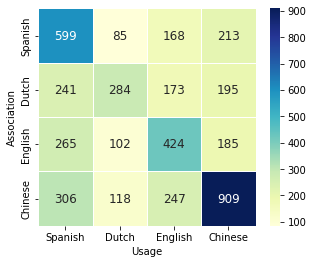

In [30]:
import matplotlib.patches as mpatches
import seaborn as sns
lang_ticks = [language_names[lang] for lang in languages]
fig, ax = plt.subplots(1, 1, sharey=False)

fig.set_figheight(4)
fig.set_figwidth(5)

nclassified_mtx = np.array([[usage_assoc_alignment["nclassified"]["bayesian"]["r123"][lang][lang2] for lang2 in languages] for lang in languages])
ax = sns.heatmap(nclassified_mtx, annot=True, linewidths=.5, xticklabels=lang_ticks, yticklabels=lang_ticks, square=True, ax=ax, fmt='g', cmap="YlGnBu",
                annot_kws={"fontsize":12})
ax.set(xlabel='Usage', ylabel='Association')
plt.savefig("figures/nclassified_by_lang.pdf",bbox_inches='tight')
plt.show()



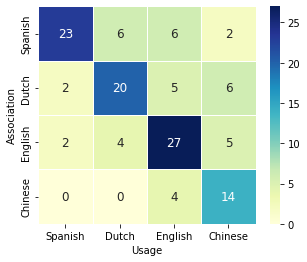

In [31]:
fig, ax = plt.subplots(1, 1, sharey=False)

fig.set_figheight(4)
fig.set_figwidth(5)
rank1_mtx = np.array([[usage_assoc_alignment["nkeywords"]["bayesian"]["r123"][lang][lang2] for lang2 in languages] for lang in languages])
ax = sns.heatmap(rank1_mtx, annot=True,  linewidths=.5, xticklabels=lang_ticks, yticklabels=lang_ticks, square=True, ax=ax, fmt='g',  cmap="YlGnBu",
                annot_kws={"fontsize":12})
ax.set(xlabel='Usage', ylabel='Association')
plt.savefig("figures/top100_by_lang_tuple.pdf",bbox_inches='tight')
plt.show()


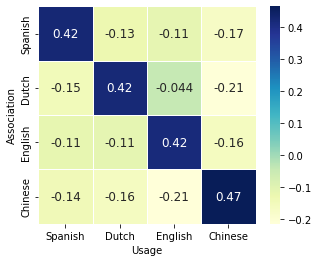

In [32]:
from src.evaluation import pearson_correlation

fig, ax = plt.subplots(1, 1, sharey=False)

fig.set_figheight(4)
fig.set_figwidth(5)
rank1_mtx = np.array([[pearson_correlation(clf_ranks["bayesian"][lang], clf_ranks['cr123ccuersc_fq'][lang2], label=None, verbose=False, outer=False)
                      for lang2 in languages] for lang in languages])
ax = sns.heatmap(rank1_mtx, annot=True,  linewidths=.5, xticklabels=lang_ticks, yticklabels=lang_ticks, square=True, ax=ax,  fmt='.2g',  cmap="YlGnBu",
                annot_kws={"fontsize":12})
ax.set(xlabel='Usage', ylabel='Association')
plt.savefig("figures/pairwise_sim_lang_assoc.pdf",bbox_inches='tight')
plt.show()

#### 6. Cultural Keywords

Note that in all following analysis, bayesian scores based on response frequency of shared vocab are from rescaled cues

In [24]:
from src.keywords import  load_and_translate_keywords

_, _, _, _, available_keywords, internal_keywords, external_keywords = load_and_translate_keywords(strong_translations, languages, source, 
                                                                                                   wordlist["bayesian"], 
                                                                                                   word_freq=word_stat["bayesian"])
    

In [25]:
print(sum([len(kwords) for kwords in internal_keywords.values()]))
print(sum([len(kwords) for kwords in external_keywords.values()]))

91
72


In [26]:
print("Total number of external keywords and internal keywords compared")
for lang, keywords in available_keywords.items():
    print("{}: {}, {}".format(lang, len(external_keywords[lang]), len(internal_keywords[lang])))
    

Total number of external keywords and internal keywords compared
en: 37, 70
es: 12, 12
nl: 4, 1
zh: 19, 8


English keywords are pretty much overrepresented, which will favour methods that are bias towards the language

##### Language classification of gold key words

In [156]:
from src.evaluation import evaluate_keyword_classifications
        
evaluate_keyword_classifications(clf_ranks, external_keywords, internal_keywords, available_keywords)

method                   : recall, mean rank (ext/int/overall)
cr123ccuersc_fq          : (0.33/0.26/0.29), (2.17/2.48/2.34)
cr123ccuersc_fq_random   : (0.15/0.20/0.18), (2.65/2.58/2.61)
cr123ccuersc_fq_always_en: (0.51/0.77/0.66), (2.06/1.49/1.74)
bayesian                 : (0.49/0.30/0.38), (1.85/2.18/2.03)
usage_assoc_0.1          : (0.36/0.31/0.33), (2.12/2.40/2.28)
usage_assoc_0.2          : (0.35/0.31/0.33), (2.08/2.38/2.25)
usage_assoc_0.3          : (0.36/0.32/0.34), (2.07/2.32/2.21)
usage_assoc_0.4          : (0.38/0.32/0.34), (2.03/2.32/2.19)
usage_assoc_0.5          : (0.38/0.35/0.36), (2.00/2.20/2.11)
usage_assoc_0.6          : (0.44/0.35/0.39), (1.93/2.19/2.07)
usage_assoc_0.7          : (0.49/0.35/0.41), (1.79/2.16/2.00)
usage_assoc_0.8          : (0.53/0.36/0.44), (1.79/2.13/1.98)
usage_assoc_0.9          : (0.50/0.33/0.40), (1.78/2.16/1.99)


#### 7. Independence Tests

In [29]:
import random, math
random.seed(2022)
from src.evaluation import evaluate_by_keyword_categories_language, recall_mean_std_by_keyword_categories, sample_wordlist_with_replacement, \
expand_keywords, expand_tr_freq

def evaluate_by_assoc_vocab(wordlist, original_tr_freq, recall_k=100, npartitions=10):
    
    def get_alpha_score_rank(freq, wordlist, smoothing, n):
        alphas_ = get_alphas(preprocess_fq(freq), wordlist, smoothing_param)
        score_ = final_score(freq, alphas_, wordlist, n)
        rank_, rank_keyword_score_, _ = rank_keyword_score(wordlist, languages, score_)
        _, _, word_sc_rank_ = sort_rank_by_score(rank_keyword_score_)
        return score_, rank_, rank_keyword_score_, word_sc_rank_
        
    
    
    smoothing_param = assoc_smoothing_param
    wordlist_clf_eval = []
    wordlist_rank_eval = []

    # wsamples_list = sample_wordlist(wordlist, npartitions, overlap=True, wreplacement=True, drop_ratio=0)
    wsamples_list = sample_wordlist_with_replacement(wordlist, original_tr_freq, npartitions)
    
    
    
    for wsamples in wsamples_list:
        tr_freq = expand_tr_freq(original_tr_freq, wsamples)
        wordlist = get_wordlist(tr_freq, languages)
        n = get_n(tr_freq)
        
        
        usage_score, usage_rank, usage_rank_keyword_score, usage_word_sc_rank = get_alpha_score_rank(tr_freq, wordlist, smoothing_param, n)
       
        usage_lt_assoc_freq = expand_tr_freq(word_stat["usage_assoc_0.2"], wsamples)
        usage_lt_assoc_score, usage_lt_assoc_rank, usage_lt_assoc_rank_keyword_score, usage_lt_assoc_word_sc_rank  = get_alpha_score_rank(
            usage_lt_assoc_freq, wordlist, smoothing_param, n)
        
        usage_gt_assoc_freq = expand_tr_freq(word_stat["usage_assoc_0.8"], wsamples)
        usage_gt_assoc_score, usage_gt_assoc_rank, usage_gt_assoc_rank_keyword_score, usage_gt_assoc_word_sc_rank = get_alpha_score_rank(
            usage_gt_assoc_freq, wordlist, smoothing_param, n)
        
    
        assoc_freq = expand_tr_freq(cr123ccuersc_fq, wsamples)
        assoc_score, assoc_rank, assoc_rank_keyword_score, assoc_word_sc_rank = get_alpha_score_rank(assoc_freq, wordlist, smoothing_param, n)
        
        clf_ranks = {"usage": usage_rank, "usage_lt_assoc": usage_lt_assoc_rank, "usage_gt_assoc": usage_gt_assoc_rank, "assoc": assoc_rank}
        clf_tuple = {"usage": sort_tuple_score(usage_score), "assoc": sort_tuple_score(assoc_score),
                     "usage_lt_assoc": sort_tuple_score(usage_lt_assoc_score), "usage_gt_assoc": sort_tuple_score(usage_gt_assoc_score)}
        
        word_sc_rank = {"usage": usage_word_sc_rank, "assoc": assoc_word_sc_rank, 
                        "usage_lt_assoc": usage_lt_assoc_word_sc_rank, "usage_gt_assoc": usage_gt_assoc_word_sc_rank}
        
        cultural_keywords, concept_words_language, expected_keywords, all_keywords_en, available_keywords,\
        internal_keywords, external_keywords = load_and_translate_keywords(strong_translations, languages, "en_lemma", wordlist)   
        
        w_count = Counter(wsamples)
        internal_keywords = expand_keywords(internal_keywords, w_count)
        external_keywords = expand_keywords(external_keywords, w_count)
        available_keywords = expand_keywords(available_keywords, w_count)
        
        int_ext_recall_mean_std = {}
        recall = {}
        for method, lang_word_rank in clf_ranks.items():
            int_ext_recall_mean_std[method] = recall_mean_std_by_keyword_categories(external_keywords, internal_keywords, 
                                                                         available_keywords, lang_word_rank, 
                                                                         excluded_language=None)
        
        wordlist_clf_eval.append(int_ext_recall_mean_std)
        
        for method, tuple_score in clf_tuple.items():
            recall[method] = get_recall_at_k(available_keywords, tuple_score)
        # wordlist_rank_eval.append(get_recall_by_range_sum(external_keywords, internal_keywords, word_sc_rank, clf_ranks, recall_k))
        wordlist_rank_eval.append(recall)
    return wordlist_clf_eval, wordlist_rank_eval

recall_k=1
nsamples = 100
wordlist_clf_eval, wordlist_rank_eval = evaluate_by_assoc_vocab(wordlist["bayesian"], tr_freq, recall_k=recall_k, npartitions=nsamples)
wordlist_rank_eval_exp = [{method: {"all": {"sum": recall}} for method, recall in rank_eval.items()} for rank_eval in wordlist_rank_eval ]

USAGE_LT_ASSOC = 80% association data + 20% usage data <br>
USAGE_GT_ASSOC = 80% usage data + 20% association data

In [464]:
from src.evaluation import pvalue_by_wordlist, sample_mean_stddev
rank_eval_idx=500
metric_names={"clf-all-mean": "mean keyword classification", "clf-all-recall": "correct keyword classification", "rank-all-recall":f"recall@{rank_eval_idx}", } 
method_list = ["usage", "assoc", "usage_lt_assoc", "usage_gt_assoc"]

mean_stddev = {}
for met in method_list:
    mean_stddev[met] = sample_mean_stddev(met, wordlist_clf_eval, wordlist_rank_eval_exp, metrics=[ "clf", "rank"], rank_eval_idx=rank_eval_idx) 
    
longest = max([len(name) for name in metric_names.values()])
for met, m_std in mean_stddev.items():
    print(f"###### {met.upper()} ######")
    for metric, mean in m_std["mean"].items():
        print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: mean={mean}, std={m_std['stddev'][metric]}")
    print()

###### USAGE ######
mean keyword classification   : mean=2.0343944848380136, std=0.08196266463730759
correct keyword classification: mean=0.3834258283127253, std=0.04045232080069833
recall@500                    : mean=0.10809160078016442, std=0.027302708369264655

###### ASSOC ######
mean keyword classification   : mean=2.339180975572763, std=0.09703371851382958
correct keyword classification: mean=0.29087109666456096, std=0.03848672904341755
recall@500                    : mean=0.13682851516989447, std=0.026885993194775852

###### USAGE_LT_ASSOC ######
mean keyword classification   : mean=2.241987793113166, std=0.09282358887314324
correct keyword classification: mean=0.3273449181330092, std=0.03901447680616413
recall@500                    : mean=0.14243823053259846, std=0.025320270029211382

###### USAGE_GT_ASSOC ######
mean keyword classification   : mean=2.0068077358095286, std=0.09126837573974382
correct keyword classification: mean=0.41492099417015416, std=0.04370272082516488
re

In [33]:
from src.evaluation import pvalue_by_wordlist
import itertools

method_pairs = list(itertools.combinations(method_list, 2))
clf_rank_pair_pvalue = pvalue_by_wordlist(method_pairs, wordlist_clf_eval, wordlist_rank_eval_exp, metrics=["rank", "clf"], rank_eval_idx=rank_eval_idx)

In [466]:
print(f"p-value over {nsamples} repeated samples for comparison in classification and rank \n")
longest = max([len(met) for met in metric_names.values()])
for clf_pair, result in clf_rank_pair_pvalue.items():
    print(f"##### {clf_pair.split('-')[0].upper()} vs. {clf_pair.split('-')[1].upper()} #####")
    
    for metric, res in result.items():
        try:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res.statistic}, pval={res.pvalue}")
        except:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res}")
    print()

p-value over 100 repeated samples for comparison in classification and rank 

##### USAGE vs. ASSOC #####
recall@500                    : 0.8
mean keyword classification   : 1.0
correct keyword classification: 0.01

##### USAGE vs. USAGE_LT_ASSOC #####
recall@500                    : 0.86
mean keyword classification   : 1.0
correct keyword classification: 0.06

##### USAGE vs. USAGE_GT_ASSOC #####
recall@500                    : 0.37
mean keyword classification   : 0.23
correct keyword classification: 0.81

##### ASSOC vs. USAGE_LT_ASSOC #####
recall@500                    : 0.61
mean keyword classification   : 0.0
correct keyword classification: 0.99

##### ASSOC vs. USAGE_GT_ASSOC #####
recall@500                    : 0.13
mean keyword classification   : 0.0
correct keyword classification: 1.0

##### USAGE_LT_ASSOC vs. USAGE_GT_ASSOC #####
recall@500                    : 0.06
mean keyword classification   : 0.0
correct keyword classification: 1.0



In [492]:
1-0.81

0.18999999999999995

In [34]:
wordlist_rank_eval_steps = {method: np.array([reval[method]["all"]["sum"] for reval in wordlist_rank_eval_exp]).T for method in wordlist_rank_eval_exp[0].keys()}   # (steps, samples)
rank_mean_estimate = {method: np.mean(wordlist_rank_eval_steps[method], axis=1) for method in wordlist_rank_eval[0].keys()}
rank_stde_estimate = {method: np.std(wordlist_rank_eval_steps[method], axis=1)/np.sqrt(nsamples) for method in wordlist_rank_eval[0].keys()}

error_estimate = {method: (rank_mean_estimate[method]-rank_stde_estimate[method], rank_mean_estimate[method]+rank_stde_estimate[method]) for method in wordlist_rank_eval[0].keys()}
clf_recall = {clf: get_recall_at_k(available_keywords, rank) for clf, rank in clf_tuple.items()}

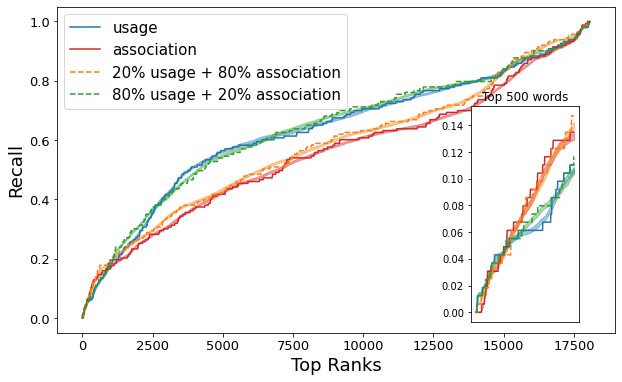

In [35]:
import warnings
warnings.filterwarnings('ignore')
from src.visualisation import compare_recall_ranks_all_methods_inset
top_n = 500

usage_assoc_met = "usage_assoc_0.6"
compare_recall_ranks_all_methods_inset(clf_recall, top_n=top_n, 
                                       inset_range=[0, top_n, 0, 0.15],
                                        method_style_dict={"bayesian": "k-", "cr123ccuersc_fq":"k-", "usage_assoc_0.2": 'k--', "usage_assoc_0.8": 'k--'},
                                        method_label_dict={"bayesian": "usage", "usage_assoc_0.2" : '20% usage + 80% association',
                                                    "cr123ccuersc_fq":"association", "usage_assoc_0.8" : '80% usage + 20% association'},
                                        method_colour_dict={"bayesian": "tab:blue", "usage_assoc_0.2" : 'tab:orange',
                                                     "cr123ccuersc_fq":"tab:red", "usage_assoc_0.8" : 'tab:green'}, 
                                       fill_between={"bayesian": error_estimate["usage"], 
                                                     "cr123ccuersc_fq": error_estimate["assoc"],
                                                    "usage_assoc_0.2": error_estimate["usage_lt_assoc"],
                                                    "usage_assoc_0.8": error_estimate["usage_gt_assoc"]}
                                      )
                

# plt.savefig("figures/usage_assoc_tuple_recall_ranks_inset_stderror.pdf")